### Pytorch를 사용하기 위해 필수로 알아야 하는 정보
1. Packages
- torch
- torch.nn 
  - RNN, Conv2d와 같은 layer, MSEloss 같은 loss function, ReLU와 같은 activation function(비선형성을 부여해 주는 활성화 함수)가 존재
- torch.optim
  - SGD(확률적 경사 하강법)과 같은 parameter을 최적화 할 수 있는 알고리즘이 저장 되어 있다.
- torch.utils.data
  - SGD의 반복 연산을 실행할 떄에 사용하는 mini batch용 함수가 저장되어 있다.
- torch.onnx
  - 다른 딥러닝 framework와 모델을 공유하기 위해서 사용하는 format이다.

In [ ]:
import torch
import torch.nn.init
import torchvision

import torchvision.datasets as dsets
import torchvision.transforms as transform
# torchvision.transforms의 경우에는 거의 모든 이미지셋에 대해서 변형을 가할 수 있도록 해준다.
# 예를 들면 cropping, color changing등이 가능하고 Tensor input, PIL input에 따라서 각기 다르게 적용되는 내용도 있다.

#### MNIST 데이터셋을 이용해서 CNN 학습 시켜보기

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777) # 이를 해 주어야 난수 발생 순서와 값이 동일하게 보장이 된다.
if device == 'cuda':
  torch.device.manual_seed_all(777)

In [ ]:
# parameter 설정해 주기
# 원래 hyperparameter이 사용자가 설정해 주는 것이고 parameter이 모델이 직접 설정하는 것인데,
# optimizer.step()을 이용해서 직접 학습을 시켜줄 것이기 때문에 parameter을 직접 설정해 주어야 한다.

learning_rate = 0.001
epochs = 15
batch_size = 100

In [ ]:
# MNIST dataset
# parameter중에 train의 경우에는 True로 설정하면 train data를 다운받는다.
mnist_Train = dsets.MNIST(root = 'MNIST_data/', train = True, 
                          transform = transform.ToTensor(),
                          download = True)
mnist_Test = dsets.MNIST(root = 'MNIST_data/', train = False,
                         transform = transform.ToTensor(),
                         download = True)

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
dataloader = torch.utils.data.DataLoader(
    dataset = mnist_Train, batch_size = batch_size, shuffle = True, drop_last = True
)

In [ ]:
# CNN Model 만들기

class CNN(torch.nn.Module):

  def __init__(self, **kwargs):
    super(CNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.fc = nn.Linear(7*7*64, bias = True)
    torch.nn.init.xavier_uniform_(self.fc.weight)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size[0], -1) # Fully Connected Layer로의 입력을 위해서 1D의 크기로 바꾸어 준다.
    out = self.fc(out)
    return out


In [ ]:
# 모델 정의
model = CNN().to(device)
loss_fn = torch.nn.CrossentropyLoss().to(device) # 비용 함수
# 비용함수에 softmax함수가 포함이 되어있음
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # gradient계산 함수
total_batch = len(data_loader) # 총 배치의 수

In [ ]:
# 모델 학습시키기
for step in range(epochs):
  avg_cost = 0

  for x, y in data_loader:
    x = x.to(device)
    y = y.to(device)
    
    # pytorch는 매번 기울기를 이전의 계산된 기울기의 값에 중첩시킨다는 특징이 존재하기 때문에 0으로 매 step마다 초기화를 시켜 주어야 한다.
    optimizer.zero_grad() 
    prediction = model(x)
    cost = loss_fn(hypothesis, y)
    # 여기서부터 back propagation
    cost.backward() 
    optimizer.step()

    avg_cost += cost / total_batch

    print('[Epoch : {:>4}] cost = {:>.9}'.format(step + 1, avg_cost))




In [ ]:
with torch.no_grad():
  x_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device) #view()함수를 이용해서 data의 차원과 shape를 바꾸어 줄 수 있다.
  y_test = mnist_test.test_labels.to(device)

  prediction = model(x_test)
  correct_prediction = torch.argmax(prediction, 1) == y_test
  accuracy = correct_prediction.float().mean()
  
  print('Accuracy : ', accuracy.item())

#### Visdom

In [ ]:
import visdom

In [ ]:
!pip install visdom

     |████████████████████████████████| 686kB 6.6MB/s 
     |████████████████████████████████| 204kB 23.6MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.9-cp37-none-any.whl size=655251 sha256=38fe4b8e1aafc28197910912b470ce07313372322510ad673fbb9c2119b4c60d
  Stored in directory: /root/.cache/pip/wheels/70/19/a7/6d589ed967f4dfefd33bc166d081257bd4ed0cb618dccfd62a
  Created wheel for torchfile: filename=torchfile-0.1.0-cp37-none-any.whl size=5713 sha256=0c0b3aad666fc0e05fb165f7987a136b0a759499f39605ffce700413983892fe
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built visdom torchfile


#### VGG Network 구현하기

In [ ]:
import visdom
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import numpy as np

class VGG(nn.Module):
  def _initialize_weights(self):
      for m in self.modules():
        if isinstance(m, nn.Conv2d):
          # kaiming_uniform_은 가중치 초기화를 He initialization을 적용하게 되는데
          # 여기서 mode = 'fan_in'이라는 것은
          # 입력 노드의 개수를 6으로 나눈뒤 절댓값을 씌운 값을 
          # 정규 분포의 boundary로 지정하는 방법을 사용해서 gradient loss를 방지하는 method이기 때문이다.
          nn.init.kaiming_uniform_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu')
          if m.bias is not None:
            nn.init.constant_(m.weight, 1)
        elif isinstance(m, nn.BatchNorm2d):
          nn.init.constant_(m.weight, 1) # 가중치의 크기만큼 1로 채워넣음
          nn.init.constant_(m.bias, 0) # 편향의 크기만큼 0으로 채워넣음
        elif isinstance(m, nn.Linear):
          nn.init.normal_(m.weight, 0, 0.01) # 가중치의 크기만큼 평균이 0이고 0.1의 표준편차를 갖도록 채움
          nn.init.constant_(m.bias, 0)

  def __init__(self, features, num_classes = 1000, init_weights = True):
    super(VGG, self).__init__()
    self.features = features #input 값
    self.avgpool = nn.AdaptiveAvgPool2d((7,7)) # 어떠한 크기의 입력이 주어져도 지정된 크기로 average pooling을 적용하는 layer
    # 이 경우에는 (7,7)의 크기로 고정

    self.classifier - nn.Sequential(
        nn.Linear(512*7*7, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, num_classes)
    ) # fully connected layer
                                                

    if init_weights: 
      self._initialize_weights()

    def forward(self, x):
      x = self.features(x)
      x = self.avgpool(x)
      x = x.view(x.size(0), -1)
      x = self.classifier(x)
      return x
    
    def _initialize_weights(self):
      for m in self.modules():
        if isinstance(m, nn.Conv2d):
          # kaiming_uniform_은 가중치 초기화를 He initialization을 적용하게 되는데
          # 여기서 mode = 'fan_in'이라는 것은
          # 입력 노드의 개수를 6으로 나눈뒤 절댓값을 씌운 값을 
          # 정규 분포의 boundary로 지정하는 방법을 사용해서 gradient loss를 방지하는 method이기 때문이다.
          nn.init.kaiming_uniform_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu')
          if m.bias is not None:
            nn.init.constant_(m.weight, 1)
        elif isinstance(m, nn.BatchNorm2d):
          nn.init.constant_(m.weight, 1) # 가중치의 크기만큼 1로 채워넣음
          nn.init.constant_(m.bias, 0) # 편향의 크기만큼 0으로 채워넣음
        elif isinstance(m, nn.Linear):
          nn.init.normal_(m.weight, 0, 0.01) # 가중치의 크기만큼 평균이 0이고 0.1의 표준편차를 갖도록 채움
          nn.init.constant_(m.bias, 0)



- VGG Model의 경우에는 (3, 3)크기의, stride와 padding의 값으로 모두 1을 갖는 Convolution layer과 stride와 kernel_size = 2인 MaxPool Layer을 갖는다. 
- 원래 Convolution Layer만 지난다면 feaure vector의 크기가 커지겠지만, Max Pool영역을 통과함으로서 크기가 줄어들게 되는 것이다.

In [44]:
def make_layers(cfg, batch_norm = False):
  layers = []
  in_channels = 3

  for v in cfg:
    if v == 'M':
      layers += [nn.MaxPool2d(kernel_size = 2, stride = 2)]
    else:
      conv2d = nn.Conv2d(in_channels, v, kernel_size = 3, padding = 1)
      if batch_norm:
        layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace = True)]
      else:
        layers += [conv2d, nn.ReLU(inplace = True)]
      in_channels = v

  return nn.Sequential(*layers)


#### 실제로 학습이 되어 있는 VGG Network를 이용해서 cifar10 dataset을 예측해보자

In [1]:
import torch
import torch.nn as nn

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import torchvision.datasets as dset



```python
import visdom
vis = visdom.Visdom

def loss_tracker(loss_plot, loss_value, num):
  vis.line(X = num,
           Y = loss_plot,
           update = 'append')
```



In [66]:
# 할당 device 설정을 해주는 것은 Pytorch에서는 필수
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [67]:
device

'cpu'

In [68]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

Files already downloaded and verified
Files already downloaded and verified


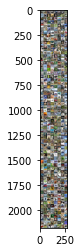

 frog plane   car   car


In [102]:
# 결과를 시각화하기 위한 함수 코드
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
  # img는 Tensor의 형태
  img = img / 2 + 0.5 # Normalize(원래 pixel의 값들은 0에서 1 사이의값들이지만 이를 zero mean의 형태로)
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

trainset = torchvision.datasets.CIFAR10(root = './CIFAR10', train = True, transform = transform, download = True)
trainloader = torch.utils.data.DataLoader(trainset, shuffle = True,batch_size = 512) 
testset = torchvision.datasets.CIFAR10(root = './CIFAR10', train=False, 
                                       download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 4,
                                         shuffle = False, num_workers = 0)
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [70]:
cfg = [32,32,'M', 64, 64,128,128,'M', 256,256,256, 512, 512, 512,'M']



In [104]:
class VGG(nn.Module):
  def __init__(self, features, num_classes = 10, init_weights = True):
    super(VGG, self).__init__()
    self.features = features 
    #input 값
    # self.avgpool = nn.AdaptiveAvgPool2d((7,7)) # 어떠한 크기의 입력이 주어져도 지정된 크기로 average pooling을 적용하는 layer
    # 이 경우에는 (7,7)의 크기로 고정
    self.classifier = nn.Sequential(
        nn.Linear(512*4*4, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, num_classes),
    ) # fully connected layer
    if init_weights:
      self._initialize_weights()
  def forward(self, x):
    x = self.features(x)
    #x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)

    return x

  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        # kaiming_uniform_은 가중치 초기화를 He initialization을 적용하게 되는데
        # 여기서 mode = 'fan_in'이라는 것은
        # 입력 노드의 개수를 6으로 나눈뒤 절댓값을 씌운 값을 
        # 정규 분포의 boundary로 지정하는 방법을 사용해서 gradient loss를 방지하는 method이기 때문이다.
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
          nn.init.constant_(m.weight, 1)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1) # 가중치의 크기만큼 1로 채워넣음
        nn.init.constant_(m.bias, 0) # 편향의 크기만큼 0으로 채워넣음
      elif isinstance(m, nn.Linear):          
        nn.init.normal_(m.weight, 0, 0.01) # 가중치의 크기만큼 평균이 0이고 0.1의 표준편차를 갖도록 채움
        nn.init.constant_(m.bias, 0)

    

In [105]:
conv = make_layers(cfg)

In [106]:
conv

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU(inplace=True)
  (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): Conv2d(256

In [107]:
import torchvision.models.vgg as vgg

In [108]:
vgg.make_layers(cfg).modules

<bound method Module.modules of Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU(inplace=True)
  (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

In [109]:
vgg16 = VGG(vgg.make_layers(cfg), 10, True).to(device)

In [110]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=

In [111]:
a = torch.Tensor(1, 3, 32, 32).to(device)
out = vgg16(a)
print(out)

tensor([[-1.4208e+34, -3.3628e+33, -4.3943e+34, -2.4628e+33,  5.3352e+33,
         -1.7760e+34,  1.2587e+34,  5.1496e+34, -1.0208e+34,  4.8416e+32]],
       grad_fn=<AddmmBackward>)


### tab의 크기를 module을 정의 하는 과정에서 너무 들여쓰기를 많이 하는 바람에 계속해서 Implemented error이 발생했다. ㅠㅠㅠㅠㅠ

In [112]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(vgg16.parameters(), lr = 0.005, momentum = 0.9)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.9)

In [ ]:
# Training
epochs = 50
for epoch in range(epochs):
  running_loss = 0.0

  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = vgg16(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    lr_scheduler.step()

    running_loss += loss.item()
    if (i%30 == 0):
      print('[%d, %5d] loss : %.3f' % (epoch + 1, i+1, running_loss / 30))
    running_loss = 0.0
  
print('Finished Training')




In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

outputs = vgg16(images.to(device))

-, predicted = torch.max(outputs, 1)




In [ ]:
correct, total = 0, 0

with torch.no_grad():
  for data in testloader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    -, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)

    correct += (predicted == labels).sum().item()

print('Accuracy : '% (100 * correct / total))